In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [2]:
!kaggle datasets download -d sumanthvrao/daily-climate-time-series-data

  0% 0.00/22.0k [00:00<?, ?B/s]
100% 22.0k/22.0k [00:00<00:00, 2.12MB/s]


In [3]:
!unzip daily-climate-time-series-data.zip

Archive:  daily-climate-time-series-data.zip
  inflating: DailyDelhiClimateTest.csv  
  inflating: DailyDelhiClimateTrain.csv  


# Import Library

In [4]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from dateutil.parser import parse
dateparse=lambda dates:parse(dates)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load Data Test and Train

In [5]:
clim_test = pd.read_csv('/content/DailyDelhiClimateTest.csv',
                         parse_dates=['date'],date_parser=dateparse)
clim_test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [6]:
clim_train = pd.read_csv('/content/DailyDelhiClimateTrain.csv',
                         parse_dates=['date'],date_parser=dateparse)
clim_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


# Check General Data Test and Train Info

In [7]:
print(clim_train.info())
print(clim_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1462 non-null   datetime64[ns]
 1   meantemp      1462 non-null   float64       
 2   humidity      1462 non-null   float64       
 3   wind_speed    1462 non-null   float64       
 4   meanpressure  1462 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 57.2 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          114 non-null    datetime64[ns]
 1   meantemp      114 non-null    float64       
 2   humidity      114 non-null    float64       
 3   wind_speed    114 non-null    float64       
 4   meanpressure  114 non-null    float64       
dtypes: datetime64[ns](1)

In [8]:
# Check missing value
print(clim_train.isnull().sum())
print(clim_test.isnull().sum())

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64
date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


In [9]:
# Check shape
print(clim_train.shape)
print(clim_test.shape)

(1462, 5)
(114, 5)


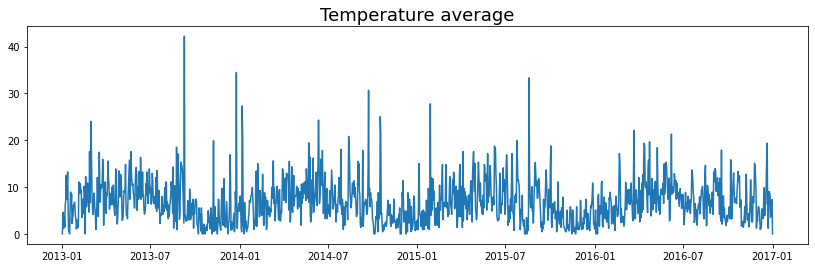

In [10]:
# plot daily climate 
date = clim_train['date'].values
wind_speed  = clim_train['wind_speed'].values
 
 
plt.figure(figsize=(14,4))
plt.plot(date, wind_speed)
plt.title('Temperature average',
          fontsize=18);

# Split Data

In [11]:
x_train, x_test , y_train, y_test  = train_test_split(wind_speed, date, test_size=0.2)
print("Total Data Train: ", len(x_train))
print("Total Data Test: ", len(x_test))

Total Data Train:  1169
Total Data Test:  293


In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
train_check = windowed_dataset(x_train, window_size=33, batch_size=50, shuffle_buffer=500)

In [14]:
val_check = windowed_dataset(x_test, window_size=33, batch_size=50, shuffle_buffer=500)


In [15]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

In [18]:
Mae = (clim_train['wind_speed'].max() - clim_train['wind_speed'].min()) * 10/100
print(Mae)

4.2219999999999995


In [19]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<1.79 and logs.get('val_mae')<1.79):
      print("\nMAE < 10% data scale")
      self.model.stop_training = True
callbacks = myCallback()

In [20]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [21]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [25]:
history_lstm = model.fit(train_check, epochs=100, validation_data = val_check, callbacks=[lr_schedule, callbacks])

Epoch 1/100
23/23 [==============================] - 12s 60ms/step - loss: 4.5132 - mae: 4.9892 - val_loss: 4.4751 - val_mae: 4.9507 - lr: 1.0000e-08
Epoch 2/100
23/23 [==============================] - 0s 15ms/step - loss: 4.4439 - mae: 4.9195 - val_loss: 4.3854 - val_mae: 4.8595 - lr: 1.1220e-08
Epoch 3/100
23/23 [==============================] - 0s 15ms/step - loss: 4.3618 - mae: 4.8371 - val_loss: 4.2871 - val_mae: 4.7595 - lr: 1.2589e-08
Epoch 4/100
23/23 [==============================] - 0s 15ms/step - loss: 4.2746 - mae: 4.7491 - val_loss: 4.1869 - val_mae: 4.6579 - lr: 1.4125e-08
Epoch 5/100
23/23 [==============================] - 0s 15ms/step - loss: 4.1855 - mae: 4.6595 - val_loss: 4.0835 - val_mae: 4.5535 - lr: 1.5849e-08
Epoch 6/100
23/23 [==============================] - 0s 18ms/step - loss: 4.0939 - mae: 4.5675 - val_loss: 3.9809 - val_mae: 4.4507 - lr: 1.7783e-08
Epoch 7/100
23/23 [==============================] - 0s 16ms/step - loss: 4.0033 - mae: 4.4764 - val_loss

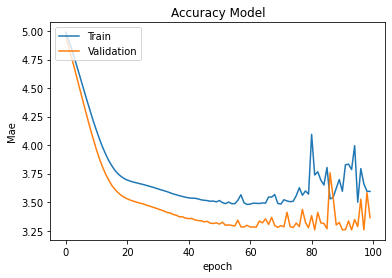

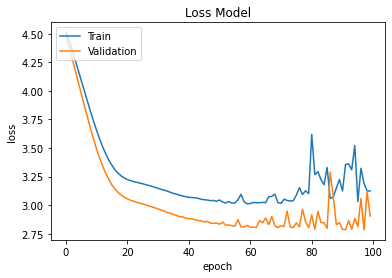

In [26]:
# Plot Accuracy
plt.plot(history_lstm.history['mae'])
plt.plot(history_lstm.history['val_mae'])
plt.title('Accuracy Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot Loss
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()